In [1]:
# Импорт основных библиотек
import numpy as np
import pandas as pd
#Импортирование библиотек, загрузка файла
import pandas as pd              #Импорт библиотеки Pandas
import numpy as np               #Импорт библиотеки Numpy
import seaborn as sns            #Импорт библиотеки Seaborn
import matplotlib.pyplot as plt  #Импорт библиотеки Matplotlib



# Импорт библиотек построения графиков и диаграмм
from matplotlib import pyplot as plt
import seaborn as sns

# Указание режима отображения диаграмм
%matplotlib inline

# Импорт основных библиотек машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler

# Импорт библиотек моделей машинного обучения
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

# Импорт библиотек отбора признаков
from sklearn.feature_selection import RFE

# Импорт библиотек оценки моделей машинного обучения
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
train_data = pd.read_parquet("train_dataset_hackaton2023_train.gzip");

In [3]:
train_data['date_diff_post'] = train_data['date_diff_post'].fillna(0)

In [4]:
# Основные статистические характеристики обучающего набора данных
train_data.describe()

,customer_id,date_diff_post,buy_post,revenue,ownareaall_sqm
count,1.212938e+07,1.212938e+07,1.212938e+07,1.212938e+07,1.212938e+07
mean,1.980954e+07,1.631231e+01,7.964846e-01,1.067995e+02,2.155130e+02
std,1.138904e+07,1.592896e+01,4.026126e-01,1.074385e+02,1.225907e+02
min,2.989100e+04,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00
25%,1.010852e+07,2.000000e+00,1.000000e+00,4.499000e+01,1.049000e+02
50%,2.127459e+07,1.200000e+01,1.000000e+00,7.998000e+01,2.104000e+02
75%,2.803856e+07,2.600000e+01,1.000000e+00,1.317725e+02,3.000000e+02
max,4.666180e+07,6.000000e+01,1.000000e+00,1.449971e+04,9.787000e+02


In [5]:
# Проверка типов данных и пропущенных значений в обучающем наборе данных
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12129384 entries, 0 to 24261978
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   customer_id     int64         
 1   date_diff_post  float64       
 2   buy_post        int64         
 3   group_name      object        
 4   revenue         float64       
 5   startdatetime   datetime64[ns]
 6   dish_name       object        
 7   ownareaall_sqm  float64       
 8   format_name     object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 925.4+ MB


In [6]:
aggregation_functions = {
    'revenue': 'sum',  # Сумма покупок
    'startdatetime': 'max',  # Последняя дата
    'dish_name': lambda x: sorted(list(set(x)), reverse=True),  # Перечисление всех блюд, которые покупал пользователь
    'ownareaall_sqm': lambda x: sorted(list(set(x)), reverse=True),  # Перечисление площадей ресторана
    'format_name': lambda x: list(x)  # Перечисление форматов ресторанов
}

train_data = train_data.groupby(['customer_id', 'group_name','buy_post', 'date_diff_post']).agg(aggregation_functions).reset_index()
train_data

,customer_id,group_name,buy_post,date_diff_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,train,1,9.0,5087.35,2023-02-01 09:55:59,"[Энергет.нап. Адреналин Раш, Эвервесс Лемон-Ла...","[463.0, 300.0]","[Отдельно стоящий без внешней зоны, Отдельно с..."
1,30477,train,1,10.0,5675.60,2022-11-25 08:53:01,"[Эвервесс Апельсин джун 0,3л б/л, Чикен Тар-Та...",[320.0],"[Отдельно стоящий без внешней зоны, Отдельно с..."
2,31426,train,1,4.0,9393.59,2023-07-01 20:54:48,"[Эвервесс Кола джун 0,3л, Сырные Медальоны (6 ...",[153.0],"[Фудкорт без туалета, Фудкорт без туалета, Фуд..."
3,44491,train,1,42.0,514.90,2023-07-08 18:10:44,"[Рожок Малина, Рожок, Кинг Фри станд, Кетчуп, ...","[139.0, 88.42]",[Отдельно стоящий без внешней зоны без туалета...
4,44939,train,1,9.0,1664.83,2022-12-25 22:38:48,"[Сырные Медальоны (3 шт.), Соус Сырный, Соус К...","[280.0, 129.27]","[Фудкорт без туалета, Фудкорт без туалета, Фуд..."
...,...,...,...,...,...,...,...,...,...
499995,46624509,train,0,0.0,935.90,2023-08-01 17:19:34,"[Чизбургер, Сырбургер Чикен New, Соус Сырный, ...",[112.53],"[Фудкорт без туалета, Фудкорт без туалета, Фуд..."
499996,46625265,train,0,0.0,1199.87,2023-07-31 15:46:52,"[Чикенбургер новый, Соус Сырный, Острые Луковы...",[120.0],"[Фудкорт с туалетом, Фудкорт с туалетом, Фудко..."
499997,46639170,train,1,10.0,1089.92,2023-07-31 21:48:49,"[Соус 1000 островов, Пиво Туборг Грин 0.5л роз...",[80.2],"[Фудкорт без туалета, Фудкорт без туалета, Фуд..."
499998,46654016,train,1,15.0,1219.93,2023-08-01 18:15:31,"[Эвервесс Кола стандарт 0,5, Эвервесс Блэк Роя...",[270.0],"[Отдельно стоящий с внешней зоной, Отдельно ст..."


In [7]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

train_data['dish_name'] = train_data['dish_name'].astype(str)
train_data['ownareaall_sqm'] = train_data['ownareaall_sqm'].astype(str)
train_data['format_name'] = train_data['format_name'].astype(str)

train_data['dish_name'] = labelencoder.fit_transform(train_data['dish_name'])
train_data['ownareaall_sqm'] = labelencoder.fit_transform(train_data['ownareaall_sqm'])
train_data['format_name'] = labelencoder.fit_transform(train_data['format_name'])

train_data['startdatetime'] = (train_data['startdatetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
train_data.drop('group_name', axis=1, inplace=True)

train_data

,customer_id,buy_post,date_diff_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,1,9.0,5087.35,1675245359,494000,112811,22460
1,30477,1,10.0,5675.60,1669366381,309400,69973,7267
2,31426,1,4.0,9393.59,1688244888,380593,11861,134216
3,44491,1,42.0,514.90,1688839844,13740,10464,3267
4,44939,1,9.0,1664.83,1672007928,48525,40894,127567
...,...,...,...,...,...,...,...,...
499995,46624509,0,0.0,935.90,1690910374,120676,3510,137160
499996,46625265,0,0.0,1199.87,1690818412,180657,5410,159500
499997,46639170,1,10.0,1089.92,1690840129,19050,129452,137160
499998,46654016,1,15.0,1219.93,1690913731,429982,37147,60796


In [8]:
# Разбивка данных на обучающий и тестовый наборы
# модуль buy_post
columns_to_drop = ['date_diff_post', 'buy_post','customer_id']
X = train_data.drop(columns_to_drop, axis=1)  # Признаки, кроме выручки
y = train_data['buy_post']  # Целевая переменная (выручка)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Создание и обучение модели градиентного бустинга (XGBoost)
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Создание и обучение модели градиентного бустинга (LightGBM)
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)

# Создание и обучение модели случайного леса
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Оценка среднеквадратичной ошибки для каждой модели
xgb_mse = mean_squared_error(y_test, xgb_pred)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
rf_mse = mean_squared_error(y_test, rf_pred)

# Вывод результатов
print(f"XGBoost MSE: {xgb_mse}")
print(f"LightGBM MSE: {lgbm_mse}")
print(f"Random Forest MSE: {rf_mse}")

# Выбор лучшей модели на основе среднеквадратичной ошибки
best_model = min([(xgb_mse, "XGBoost"), (lgbm_mse, "LightGBM"), (rf_mse, "Random Forest")])[1]
print(f"Лучшая модель для определения оттока: {best_model}")

XGBoost MSE: 0.26997
LightGBM MSE: 0.26988
Random Forest MSE: 0.28214
Лучшая модель для определения оттока: LightGBM


In [9]:
train_data

,customer_id,buy_post,date_diff_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,1,9.0,5087.35,1675245359,494000,112811,22460
1,30477,1,10.0,5675.60,1669366381,309400,69973,7267
2,31426,1,4.0,9393.59,1688244888,380593,11861,134216
3,44491,1,42.0,514.90,1688839844,13740,10464,3267
4,44939,1,9.0,1664.83,1672007928,48525,40894,127567
...,...,...,...,...,...,...,...,...
499995,46624509,0,0.0,935.90,1690910374,120676,3510,137160
499996,46625265,0,0.0,1199.87,1690818412,180657,5410,159500
499997,46639170,1,10.0,1089.92,1690840129,19050,129452,137160
499998,46654016,1,15.0,1219.93,1690913731,429982,37147,60796


In [10]:
from sklearn.metrics import f1_score

y_train = (y_train > 0.5).astype(int)
y_test = (y_test > 0.5).astype(int)

xgb_f1_score = f1_score(y_test, xgb_pred)
lgbm_f1_score = f1_score(y_test, lgbm_pred)
rf_f1_score = f1_score(y_test, rf_pred)

# Вывод результатов F1-скора
print(f"XGBoost F1-score: {xgb_f1_score}")
print(f"LightGBM F1-score: {lgbm_f1_score}")
print(f"Random Forest F1-score: {rf_f1_score}")

XGBoost F1-score: 0.8363907423231459
LightGBM F1-score: 0.8384145611304037
Random Forest F1-score: 0.8268378607288841


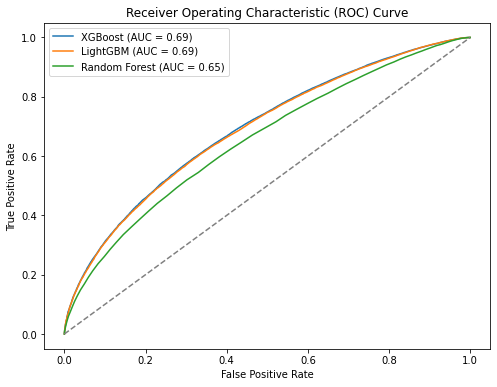

In [11]:
# ROC и AUC графики
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Получение вероятностей для получения ROC и AUC
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
lgbm_proba = lgbm_model.predict_proba(X_test)[:, 1]
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Вычисление ROC и AUC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)

xgb_auc = roc_auc_score(y_test, xgb_proba)
lgbm_auc = roc_auc_score(y_test, lgbm_proba)
rf_auc = roc_auc_score(y_test, rf_proba)

# Построение ROC графика
plt.figure(figsize=(8, 6))
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(lgbm_fpr, lgbm_tpr, label=f'LightGBM (AUC = {lgbm_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [12]:
# Разбивка данных на обучающий и тестовый наборы
# модуль buy_post
columns_to_drop = ['date_diff_post','customer_id']
X_Regressor = train_data.drop(columns_to_drop, axis=1)  # Признаки, кроме выручки
y_Regressor = train_data['date_diff_post']  # Целевая переменная (выручка)
X_train_Regressor, X_test_Regressor, y_train_Regressor, y_test_Regressor = train_test_split(X_Regressor, y_Regressor, test_size=0.2, random_state=42)


# Создание и обучение модели градиентного бустинга (XGBoost)
xgb_model_Regressor = XGBRegressor()
xgb_model_Regressor.fit(X_train_Regressor, y_train_Regressor)
xgb_pred_Regressor = xgb_model_Regressor.predict(X_test_Regressor)

# Создание и обучение модели градиентного бустинга (LightGBM)
lgbm_model_Regressor = LGBMRegressor()
lgbm_model_Regressor.fit(X_train_Regressor, y_train_Regressor)
lgbm_pred_Regressor = lgbm_model_Regressor.predict(X_test_Regressor)

# Создание и обучение модели случайного леса
rf_model_Regressor = RandomForestRegressor()
rf_model_Regressor.fit(X_train_Regressor, y_train_Regressor)
rf_pred_Regressor = rf_model_Regressor.predict(X_test_Regressor)

# Оценка среднеквадратичной ошибки для каждой модели
xgb_mse_Regressor = mean_squared_error(y_test_Regressor, xgb_pred_Regressor)
lgbm_mse_Regressor = mean_squared_error(y_test_Regressor, lgbm_pred_Regressor)
rf_mse_Regressor = mean_squared_error(y_test_Regressor, rf_pred_Regressor)

# Вывод результатов
print(f"XGBoost MSE: {xgb_mse_Regressor}")
print(f"LightGBM MSE: {lgbm_mse_Regressor}")
print(f"Random Forest MSE: {rf_mse_Regressor}")

# Выбор лучшей модели на основе среднеквадратичной ошибки
best_model_Regressor = min([(xgb_mse_Regressor, "XGBoost"), (lgbm_mse_Regressor, "LightGBM"), (rf_mse_Regressor, "Random Forest")])[1]
print(f"Лучшая модель для определения date_diff_post: {best_model_Regressor}")

XGBoost MSE: 129.29659041441744
LightGBM MSE: 131.5945255822717
Random Forest MSE: 137.22006547700002
Лучшая модель для определения date_diff_post: XGBoost


In [13]:
from sklearn.metrics import mean_absolute_error
xgb_mae_Regressor = mean_absolute_error(y_test_Regressor, xgb_pred_Regressor)
lgbm_mae_Regressor = mean_absolute_error(y_test_Regressor, lgbm_pred_Regressor)
rf_mae_Regressor = mean_absolute_error(y_test_Regressor, rf_pred_Regressor)

# Вывод результатов MAE
print(f"XGBoost MAE: {xgb_mae_Regressor}")
print(f"LightGBM MAE: {lgbm_mae_Regressor}")
print(f"Random Forest MAE: {rf_mae_Regressor}")

best_model_Regressor = min([(xgb_mse_Regressor, "XGBoost"), (lgbm_mse_Regressor, "LightGBM"), (rf_mse_Regressor, "Random Forest")])[1]
print(f"Лучшая модель для определения date_diff_post по MAE: {best_model_Regressor}")

XGBoost MAE: 8.014162998562677
LightGBM MAE: 8.029491921117412
Random Forest MAE: 8.123149100000003
Лучшая модель для определения date_diff_post по MAE: XGBoost


In [14]:
from sklearn.metrics import r2_score

xgb_r2_Regressor = r2_score(y_test_Regressor, xgb_pred_Regressor)
lgbm_r2_Regressor = r2_score(y_test_Regressor, lgbm_pred_Regressor)
rf_r2_Regressor = r2_score(y_test_Regressor, rf_pred_Regressor)

print(f"XGBoost R²: {xgb_r2_Regressor}")
print(f"LightGBM R²: {lgbm_r2_Regressor}")
print(f"Random Forest R²: {rf_r2_Regressor}")

best_model_Regressor = min([(xgb_mse_Regressor, "XGBoost"), (lgbm_mse_Regressor, "LightGBM"), (rf_mse_Regressor, "Random Forest")])[1]
print(f"Лучшая модель для определения date_diff_post по R²: {best_model_Regressor}")

XGBoost R²: 0.5622134952261244
LightGBM R²: 0.5544328955822555
Random Forest R²: 0.5353853287432115
Лучшая модель для определения date_diff_post по R²: XGBoost


In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Рассчет RMSE для каждой модели
xgb_rmse_Regressor = np.sqrt(mean_squared_error(y_test_Regressor, xgb_pred_Regressor))
lgbm_rmse_Regressor = np.sqrt(mean_squared_error(y_test_Regressor, lgbm_pred_Regressor))
rf_rmse_Regressor = np.sqrt(mean_squared_error(y_test_Regressor, rf_pred_Regressor))

# Вывод результатов
print(f"XGBoost RMSE: {xgb_rmse_Regressor}")
print(f"LightGBM RMSE: {lgbm_rmse_Regressor}")
print(f"Random Forest RMSE: {rf_rmse_Regressor}")

# Выбор лучшей модели на основе RMSE
best_model_rmse_Regressor = min([(xgb_rmse_Regressor, "XGBoost"), (lgbm_rmse_Regressor, "LightGBM"), (rf_rmse_Regressor, "Random Forest")])[1]
print(f"Лучшая модель для определения date_diff_post: {best_model_rmse_Regressor}")

XGBoost RMSE: 11.37086586036514
LightGBM RMSE: 11.47146571202964
Random Forest RMSE: 11.714096869882885
Лучшая модель для определения date_diff_post: XGBoost


In [16]:
#генерация фалйов
test_data = pd.read_parquet("test_dataset_hackaton2023_test.gzip");  # Загрузите тестовые данные или используйте другой метод для загрузки данных
aggregation_functions = {
    'revenue': 'sum',  # Сумма покупок
    'startdatetime': 'max',  # Последняя дата
    'dish_name': lambda x: sorted(list(set(x)), reverse=True),  # Перечисление всех блюд, которые покупал пользователь
    'ownareaall_sqm': lambda x: sorted(list(set(x)), reverse=True),  # Перечисление площадей ресторана
    'format_name': lambda x: sorted(list(set(x)), reverse=True)  # Перечисление форматов ресторанов
}

test_data = test_data.groupby(['customer_id', 'group_name']).agg(aggregation_functions).reset_index()


test_data['dish_name'] = test_data['dish_name'].astype(str)
test_data['ownareaall_sqm'] = test_data['ownareaall_sqm'].astype(str)
test_data['format_name'] = test_data['format_name'].astype(str)

test_data['dish_name'] = labelencoder.fit_transform(test_data['dish_name'])
test_data['ownareaall_sqm'] = labelencoder.fit_transform(test_data['ownareaall_sqm'])
test_data['format_name'] = labelencoder.fit_transform(test_data['format_name'])

test_data['startdatetime'] = (test_data['startdatetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
test_data.drop('group_name', axis=1, inplace=True)


# Применение модели к данным
predicted_values = lgbm_model.predict(test_data.drop('customer_id', axis=1))  # Замените эту строку кода на вызов вашей модели для предсказания значений

# Формирование файла CSV
# Создание нового DataFrame с предсказанными значениями
output_data = test_data[['customer_id']]  # Копирование 'customer_id' и 'startdatetime' из тестовых данных
output_data['buy_post'] = predicted_values

<ipython-input-16-0a52955a54c5>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_data['buy_post'] = predicted_values


In [17]:
lgbm_model.predict_proba(test_data.drop('customer_id', axis=1))

array([[0.27970351, 0.72029649],
       [0.07186754, 0.92813246],
       [0.06863794, 0.93136206],
       ...,
       [0.10810382, 0.89189618],
       [0.10346584, 0.89653416],
       [0.07780422, 0.92219578]])

In [18]:
new_order = ['customer_id', 'buy_post', 'revenue', 'startdatetime', 'dish_name', 'ownareaall_sqm', 'format_name']
train_data_reordered = test_data.reindex(columns=new_order)
train_data_reordered['buy_post'] = predicted_values
predicted_values_regress = xgb_model_Regressor.predict(train_data_reordered.drop('customer_id', axis=1))

output_data['startdatetime'] =test_data['startdatetime']
output_data['prob_score'] = lgbm_model.predict_proba(test_data.drop('customer_id', axis=1))[:, 1]


output_data['date_diff_post'] = predicted_values_regress
output_data['date_diff_post'] = output_data['date_diff_post'].astype(int)
output_data.loc[output_data['buy_post'] == 0, 'date_diff_post'] = 0
output_data

<ipython-input-18-5ff2f6d8df14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_data['startdatetime'] =test_data['startdatetime']
<ipython-input-18-5ff2f6d8df14>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_data['prob_score'] = lgbm_model.predict_proba(test_data.drop('customer_id', axis=1))[:, 1]
<ipython-input-18-5ff2f6d8df14>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,customer_id,buy_post,startdatetime,prob_score,date_diff_post
0,52341,1,1678287228,0.720296,30
1,69175,1,1690484802,0.928132,14
2,73427,1,1677679004,0.931362,7
3,134577,0,1664125154,0.364565,0
4,156357,1,1675013457,0.812450,24
...,...,...,...,...,...
112329,46540272,1,1690580262,0.831563,15
112330,46569275,1,1690829887,0.884195,9
112331,46601088,1,1690825914,0.891896,10
112332,46632765,1,1690911191,0.896534,0


In [19]:
# Сохранение в CSV
output_data.to_csv('predicted_output1.csv', index=False,sep=';')

In [20]:
total_revenue = test_data['revenue'].sum()
print(total_revenue)

270218680.57


In [21]:
unique_startdatetimes = test_data['startdatetime'].nunique()
print(unique_startdatetimes)

111750


In [22]:
orders_per_date_format = test_data.groupby(['startdatetime', 'format_name']).size().reset_index(name='order_count')
orders_per_date_format

,startdatetime,format_name,order_count
0,1662120533,6,1
1,1662126700,179,1
2,1662133894,55,1
3,1662139568,99,1
4,1662147401,101,1
...,...,...,...
112280,1690930205,160,1
112281,1690930845,130,1
112282,1690931235,137,1
112283,1690932481,6,1
